In [1]:
import numpy as np
import os, sys, librosa
# import pandas as pd
from scipy import signal
from scipy import linalg
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import IPython.display as ipd
from numba import jit

import libfmp
import libfmp.c8


## Saliance Based Frequency Trajectory

In [2]:
def sonify_trajectory_with_sinusoid(traj, audio_len, Fs=22050, amplitude=0.3, smooth_len=11):
    """Sonification of trajectory with sinusoidal

    Notebook: C8/C8S2_FundFreqTracking.ipynb

    Args:
        traj (np.ndarray): F0 trajectory (time in seconds, frequency in Hz)
        audio_len (int): Desired audio length in samples
        Fs (scalar): Sampling rate (Default value = 22050)
        amplitude (float): Amplitude (Default value = 0.3)
        smooth_len (int): Length of amplitude smoothing filter (Default value = 11)

    Returns:
        x_soni (np.ndarray): Sonification
    """
    # unit confidence if not specified
    if traj.shape[1] < 3:
        confidence = np.zeros(traj.shape[0])
        confidence[traj[:, 1] > 0] = amplitude
    else:
        confidence = traj[:, 2]

    # initialize
    x_soni = np.zeros(audio_len)
    amplitude_mod = np.zeros(audio_len)

    # Computation of hop size
    # sine_len = int(2 ** np.round(np.log(traj[1, 0]*Fs) / np.log(2)))
    sine_len = int(traj[1, 0] * Fs)

    t = np.arange(0, sine_len) / Fs
    phase = 0

    # loop over all F0 values, insure continuous phase
    for idx in np.arange(0, traj.shape[0]):
        cur_f = traj[idx, 1]
        cur_amp = confidence[idx]

        if cur_f == 0:
            phase = 0
            continue

        cur_soni = np.sin(2*np.pi*(cur_f*t+phase))
        diff = np.maximum(0, (idx+1)*sine_len - len(x_soni))
        if diff > 0:
            x_soni[idx * sine_len:(idx + 1) * sine_len - diff] = cur_soni[:-diff]
            amplitude_mod[idx * sine_len:(idx + 1) * sine_len - diff] = cur_amp
        else:
            x_soni[idx*sine_len:(idx+1)*sine_len-diff] = cur_soni
            amplitude_mod[idx*sine_len:(idx+1)*sine_len-diff] = cur_amp

        phase += cur_f * sine_len / Fs
        phase -= 2 * np.round(phase/2)

    # filter amplitudes to avoid transients
    amplitude_mod = np.convolve(amplitude_mod, np.hanning(smooth_len)/np.sum(np.hanning(smooth_len)), 'same')
    x_soni = x_soni * amplitude_mod
    return x_soni



def cents_to_hz(F_cent, F_ref=55.0):
    """Converts frequency in cents to Hz

    Notebook: C8/C8S2_FundFreqTracking.ipynb

    Args:
        F_cent (float or np.ndarray): Frequency in cents
        F_ref (float): Reference frequency in Hz (Default value = 55.0)

    Returns:
        F (float or np.ndarray): Frequency in Hz
    """
    F = F_ref * 2 ** (F_cent / 1200)
    return F



def hz_to_cents(F, F_ref=55.0):
    """Converts frequency in Hz to cents

    Notebook: C8/C8S2_FundFreqTracking.ipynb

    Args:
        F (float or np.ndarray): Frequency value in Hz
        F_ref (float): Reference frequency in Hz (Default value = 55.0)

    Returns:
        F_cent (float or np.ndarray): Frequency in cents
    """
    F_cent = 1200 * np.log2(F / F_ref)
    return F_cent

In [3]:
def visualize_salience_traj_constraints(Z, T_coef, F_coef_cents, F_ref=55.0, colorbar=True, cmap='gray_r',
                                        figsize=(7, 4), traj=None, constraint_region=None, ax=None):
    """Visualize salience representation with optional F0-trajectory and constraint regions

    Notebook: C8/C8S2_FundFreqTracking.ipynb

    Args:
        Z: Salience representation
        T_coef: Time axis
        F_coef_cents: Frequency axis in cents
        F_ref: Reference frequency (Default value = 55.0)
        colorbar: Show or hide colorbar (Default value = True)
        cmap: Color map (Default value = 'gray_r')
        figsize: Figure size (Default value = (7, 4))
        traj: F0 trajectory (time in seconds, frequency in Hz) (Default value = None)
        constraint_region: Constraint regions, row-format: (t_start_sec, t_end_sec, f_start_hz, f_end,hz)
            (Default value = None)
        ax: Handle to existing axis (Default value = None)

    Returns:
        fig: Handle to figure
        ax: Handle to cent axis
        ax_f: Handle to frequency axis
    """
    fig = None
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)

    sal = ax.imshow(Z, extent=[T_coef[0], T_coef[-1], F_coef_cents[0], F_coef_cents[-1]],
                    cmap=cmap, origin='lower', aspect='auto', interpolation='nearest')

    y_ticklabels_left = np.arange(F_coef_cents[0], F_coef_cents[-1]+1, 1200)
    ax.set_yticks(y_ticklabels_left)
    ax.set_yticklabels(y_ticklabels_left)
    ax.set_ylabel('Frequency (Cents)')

    if colorbar:
        plt.colorbar(sal, ax=ax, pad=0.1)

    ax_f = ax.twinx()  # instantiate a second axes that shares the same y-axis
    ax_f.set_yticks(y_ticklabels_left - F_coef_cents[0])
    y_ticklabels_right = cents_to_hz(y_ticklabels_left, F_ref).astype(int)
    ax_f.set_yticklabels(y_ticklabels_right)
    ax_f.set_ylabel('Frequency (Hz)')

    # plot contour
    if traj is not None:
        traj_plot = traj[traj[:, 1] > 0, :]
        traj_plot[:, 1] = hz_to_cents(traj_plot[:, 1], F_ref)
        ax.plot(traj_plot[:, 0], traj_plot[:, 1], color='r', markersize=4, marker='.', linestyle='')

    # plot constraint regions
    if constraint_region is not None:
        for row in constraint_region:
            t_start = row[0]  # sec
            t_end = row[1]  # sec
            f_start = row[2]  # Hz
            f_end = row[3]  # Hz
            ax.add_patch(matplotlib.patches.Rectangle((
                t_start, hz_to_cents(f_start, F_ref)), width=t_end-t_start,
                height=hz_to_cents(f_end, F_ref)-hz_to_cents(f_start, F_ref),
                fill=False, edgecolor='k', linewidth=3, zorder=2))

    ax.set_xlabel('Time (seconds)')

    if fig is not None:
        plt.tight_layout()

    return fig, ax, ax_f



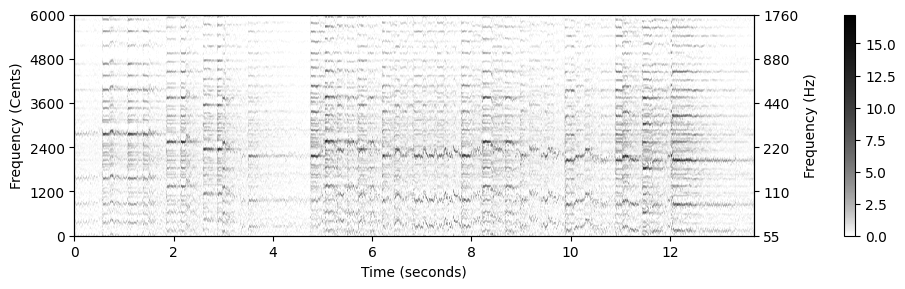

In [4]:

x, Fs = librosa.load("audio_files/sitar4_2.wav", sr=None)
x_duration = len(x)/Fs

# Computation of salience representation
N = 1024
H = 128
R = 10
F_min = 55.0
F_max = 1760.0
num_harm = 8
freq_smooth_len = 11
alpha = 0.9
gamma = 0.1

Z, F_coef_hertz, F_coef_cents = libfmp.c8.compute_salience_rep(x, Fs, N=N, H=H, R=R, 
                    F_min=F_min, F_max=F_max, num_harm=num_harm, 
                    freq_smooth_len=freq_smooth_len, alpha=alpha, gamma=gamma)
T_coef = (np.arange(Z.shape[1]) * H) / Fs

# Visualization
figsize = (10,3)
cmap = libfmp.b.compressed_gray_cmap(alpha=5)
visualize_salience_traj_constraints(Z, T_coef, F_coef_cents, F_ref=F_min, figsize=figsize, cmap=cmap, 
                                    colorbar=True, ax=None)
plt.show()

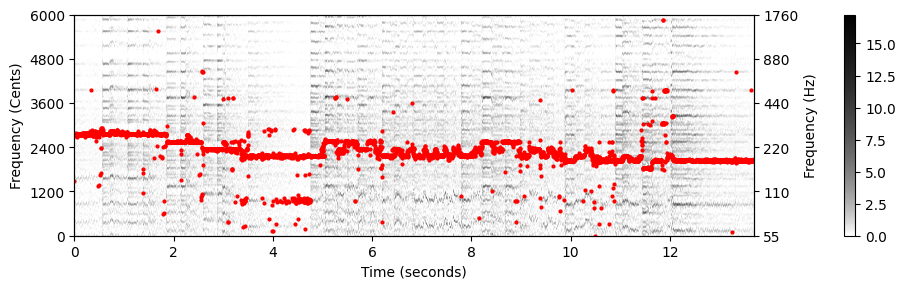

F0 sonification (right channel), original recording (left channel)


In [5]:
# Frequency trajectory via maximization
index_max = np.argmax(Z, axis=0)
traj = np.hstack((T_coef.reshape(-1, 1), F_coef_hertz[index_max].reshape(-1, 1)))

# Visualization
figsize = (10,3)
cmap = libfmp.b.compressed_gray_cmap(alpha=5)
visualize_salience_traj_constraints(Z, T_coef, F_coef_cents, F_ref=F_min, figsize=figsize, cmap=cmap, 
                                    colorbar=True, traj=traj, ax=None)
plt.show()

# Sonification
x_traj_mono = sonify_trajectory_with_sinusoid(traj, len(x), Fs, smooth_len=11)
x_traj_stereo = np.vstack((x.reshape(1,-1), x_traj_mono.reshape(1,-1)))  
print('F0 sonification (right channel), original recording (left channel)')
ipd.display(ipd.Audio(x_traj_stereo, rate=Fs))

## Continuity Constraints

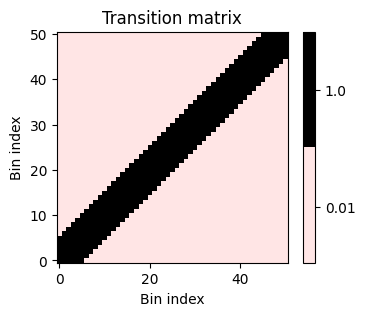

In [6]:
# @jit(nopython=True)
def define_transition_matrix(B, tol=0, score_low=0.01, score_high=1.0):
    """Generate transition matrix

    Notebook: C8/C8S2_FundFreqTracking.ipynb

    Args:
        B (int): Number of bins
        tol (int): Tolerance parameter for transition matrix (Default value = 0)
        score_low (float): Score (low) for transition matrix (Default value = 0.01)
        score_high (float): Score (high) for transition matrix (Default value = 1.0)

    Returns:
        T (np.ndarray): Transition matrix
    """
    col = np.ones((B,)) * score_low
    col[0:tol+1] = np.ones((tol+1, )) * score_high
    T = linalg.toeplitz(col)
    return T

# Compute transition matrix
T = define_transition_matrix(B=51, tol=5)

# Plot
colorList = np.array([[1,0.9,0.9,1],[0,0,0,1]])
cmap = ListedColormap(colorList) 
plt.figure(figsize=(4,3))
im = plt.imshow(T, origin='lower', cmap=cmap)
plt.title('Transition matrix')
plt.xlabel('Bin index')
plt.ylabel('Bin index')
ax_cb = plt.colorbar(im)
ax_cb.set_ticks(np.array([0.25, 0.75]))
ax_cb.set_ticklabels(np.array([np.min(T), np.max(T)])) 